In [2]:
# The following code is a Reinforcement Learning Algorithm that uses Q-learning to teach an agent how
# to keep the lift constant by modifying the angle of attack under a wind speed that changes randomly.

# In this model, the agent is controlling the angle of attack of a NACA-0015 Airfoil. The Airfoil is not
# moving and doesn't have any additional thrust. So the lift being generated is purely Aerodynamic lift.
# The environment is composed by two main states, the current angle of attack, and current wind speed. In
# this case, the current angle of attack is the state that the agent can modify (by using an action). The 
# wind speed is a factor from the environment that is not under the control of the agent.

In [3]:
import numpy as np
import pandas as pd

# Define the range of wind speeds and the number of states
wind_speed_range = (0, 100) #dm/s
wind_speed_states = 100
wind_speed_interval = (wind_speed_range[1] - wind_speed_range[0]) / wind_speed_states
wind_speed_states_list = [wind_speed_range[0] + i * wind_speed_interval for i in range(wind_speed_states)]

# Define the range of angles of attack and the number of states
angle_range = (-15, 15)
angle_states = 30
angle_interval = (angle_range[1] - angle_range[0]) / angle_states
angle_states_list = [angle_range[0] + i * angle_interval for i in range(angle_states)]

# Define the number of actions
actions = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5] # angle change

counter = 0 #counts the number of times it takes for algorithm to keep the lift constant within loop


In [4]:
# Define the function to calculate the lift of the airfoil
def lift(angle_of_attack, wind_speed):
    wind = wind_speed/10 #convert windspeed to m/s
    # Calculate the Reynolds number
    air_density = 1.225 # kg/m^3 (sea level)
    air_viscosity = 1.78e-5 # Ns/m^2 (sea level)
    chord_length = 0.15 # m (geometry of the NACA 0015 airfoil)
    reynolds_number = wind_speed * chord_length / air_viscosity
    
    # Calculate the lift coefficient
    C_l_alpha = 2 * np.pi / 180
    C_l_0 = 0.0060
    lift_coefficient = C_l_alpha * angle_of_attack + C_l_0
    
    # Calculate the lift force
    lift_force = 0.5 * lift_coefficient * air_density * wind ** 2 * chord_length
    
    return lift_force

In [5]:
# Miscellaneous functions to aid the functioning of the code
def find_closest_index(value, list_values):
    closest_index = 0
    closest_value = float("inf")
    for i, list_value in enumerate(list_values):
        if abs(value - list_value) < closest_value:
            closest_value = abs(value - list_value)
            closest_index = i
    return closest_index

In [6]:
# Function to convert a continuous angle of attack to its corresponding discrete value
def get_discrete_value(value, values):
    return np.argmin(np.abs(np.array(values) - value))

In [7]:
# Initialize the table
table = []
headers = ['Wind Speed', 'Angle', 'Lift', 'Reward', 'counter']
table.append(headers)

# Define the Q-table and some initial parameters
q_table = np.zeros((wind_speed_states, angle_states, len(actions)))
alpha = 0.1
gamma = 0.9
epsilon = 0.1
# maximum number of episodes
max_episodes = 1000
max_steps = 100

In [8]:
def rewards(state, action, next_state, goal_state):
    lift_threshold = 0.1  # within 10% of desired value
    better_threshold = 0.01 # within 1% of desired value
    
    if next_state == goal_state:
        return 10 # high reward for reaching the goal
    else:
        diff_lift = abs(next_state - goal_state)
        if diff_lift > lift_threshold:
            return -1 # penalty for not reaching the goal
        elif better_threshold < diff_lift < lift_threshold:
            return 1 # neutral reward for being close to the goal
        elif diff_lift < better_threshold:
            return 3

In [9]:
def New_V(current_wind_speed, wind_speed_states_list):
    # Define the range of wind speed changes
    wind_speed_change_range = [-10, 10] #in cm/s

    # Generate a random wind speed change value within the defined range
    wind_speed_change = np.random.randint(-10,10)
    # Calculate the new wind speed
    new_wind_speed = current_wind_speed + wind_speed_change

    # Ensure that the new wind speed is within the range of possible wind speeds
    if new_wind_speed < 0:
        new_wind_speed = 0
    elif new_wind_speed >= 100:
        while new_wind_speed >= 100:
            wind_speed_change = np.random.randint(-10,10)
            new_wind_speed = current_wind_speed + wind_speed_change

    return new_wind_speed

In [10]:
# Define the Q-learning algorithm
for episode in range(max_episodes):
    # Initialize the state and the lift
    current_wind_speed = 50 # dm/s
    current_angle = 5 # degrees
    current_lift = lift(current_angle, current_wind_speed)
    goal_lift = lift(5,50)
    counter = 0
        
    # Run the Q-learning algorithm
    for _ in range(max_steps):
        counter += 1
        new_wind_speed = New_V(current_wind_speed, wind_speed_states) #change windspeed
        
        # Choose an action based on the Q-table and epsilon-greedy strategy
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(0, len(actions))
        else:
            action = np.argmax(q_table[current_wind_speed, current_angle, :])
        
        # Calculate the new lift and the new state
        new_angle = current_angle + actions[action]
        
        if new_angle < angle_range[0]:
            new_angle = angle_range[0]
        elif new_angle >= angle_range[1]:
            new_angle = angle_range[1] - 1
        
        new_lift = lift(new_angle, new_wind_speed)
        current_lift = lift(current_angle, current_wind_speed)
        
        # Reward Calculation
        reward = rewards(current_lift, action, new_lift, goal_lift)
        
        # Update Q-table
        q_table[current_wind_speed, current_angle, action] = \
        (1 - alpha) * q_table[current_wind_speed, current_angle, action] + \
        alpha * (reward + gamma * np.max(q_table[new_wind_speed, new_angle, :]))
        
        # Update the current state to the new state
        current_wind_speed = new_wind_speed
        current_angle = new_angle
        epsilon = epsilon - 0.001 #make agent choices more deterministic with every iteration
    
        # Print some output to track progress
        table.append([current_wind_speed, current_angle, current_lift, reward, counter])   
    if episode % 100 == 0:
        print(f"Episode {episode} completed.")


Episode 0 completed.
Episode 100 completed.
Episode 200 completed.
Episode 300 completed.
Episode 400 completed.
Episode 500 completed.
Episode 600 completed.
Episode 700 completed.
Episode 800 completed.
Episode 900 completed.


In [12]:
q_table

array([[[-1.53419645, -1.54575937, -1.51458289, ..., -1.51082929,
         -1.54643503, -1.52737054],
        [-1.51030438, -1.54791348, -1.53336902, ..., -1.5557926 ,
         -1.49053466, -1.49939573],
        [-1.62775352, -1.62782392, -1.61408735, ..., -1.6153518 ,
         -1.56787956, -1.55120447],
        ...,
        [-1.42796419, -1.41389204, -1.33661383, ..., -1.43211499,
         -1.46380452, -1.41059779],
        [-1.43817393, -1.48250671, -1.46160377, ..., -1.47313187,
         -1.41699603, -1.42333693],
        [-1.4557534 , -1.5017307 , -1.48233315, ..., -1.52031397,
         -1.51110578, -1.49107696]],

       [[-0.47168832, -0.45914637, -0.41932402, ..., -0.57069197,
         -0.50009716, -0.46113013],
        [-0.48954651, -0.50037581, -0.53463324, ..., -0.49978456,
         -0.47475506, -0.48420303],
        [-0.57241616, -0.53131177, -0.63710621, ..., -0.52159135,
         -0.58333416, -0.593237  ],
        ...,
        [-0.50044856, -0.38461097, -0.4686306 , ..., -

In [13]:
#observe training progress
table

[['Wind Speed', 'Angle', 'Lift', 'Reward', 'counter'],
 [41, 0, 0.4146615625674476, -1, 1],
 [33, -5, 0.009266512499999999, -1, 2],
 [39, -10, -0.16862035165438014, -1, 3],
 [47, -15, -0.47940665183207015, -1, 4],
 [55, -15, -1.0504764200537902, -1, 5],
 [64, -15, -1.4385202221198345, -1, 6],
 [57, -15, -1.9478277123315184, -1, 7],
 [59, -15, -1.5450420501379645, -1, 8],
 [57, -15, -1.655368229156742, -1, 9],
 [51, -15, -1.5450420501379645, -1, 10],
 [44, -15, -1.236889619085517, -1, 11],
 [41, -15, -0.9206529421566942, -1, 12],
 [40, -15, -0.7993892540110552, -1, 13],
 [30, -15, -0.7608702001294992, -1, 14],
 [39, -15, -0.4279894875728434, -1, 15],
 [42, -15, -0.7233022339981051, -1, 16],
 [39, -15, -0.838859395642773, -1, 17],
 [39, -15, -0.7233022339981051, -1, 18],
 [35, -15, -0.7233022339981051, -1, 19],
 [31, -15, -0.5825412469741479, -1, 20],
 [26, -15, -0.4569976639527805, -1, 21],
 [18, -15, -0.32146765955471346, -1, 22],
 [27, -15, -0.1540762155262236, -1, 23],
 [28, -15, -0.

In [14]:
# Goal lift for training process
goal_lift = lift(5,50)
print(goal_lift)

0.4146615625674476


In [15]:
# Test Q-learning algorithm
table2 = []
for episode in range(max_episodes):
    # Initialize the state and the lift
    current_wind_speed = 1 # dm/s
    current_angle = 10 # degrees
    current_lift = lift(current_angle, current_wind_speed)
    goal_lift = lift(10,1)
    counter = 0
        
    # Run the Q-learning algorithm
    for _ in range(max_steps):
        counter += 1
        new_wind_speed = New_V(current_wind_speed, wind_speed_states) #change windspeed
        
        # Choose an action based on the Q-table (full deterministic)
        action = np.argmax(q_table[current_wind_speed, current_angle, :])
        
        # Calculate the new lift and the new state
        new_angle = current_angle + actions[action]
        
        if new_angle < angle_range[0]:
            new_angle = angle_range[0]
        elif new_angle >= angle_range[1]:
            new_angle = angle_range[1] - 1
        
        new_lift = lift(new_angle, new_wind_speed)
        current_lift = lift(current_angle, current_wind_speed)
        
        # Reward Calculation
        reward = rewards(current_lift, action, new_lift, goal_lift)
        
        # Update the current state to the new state
        current_wind_speed = new_wind_speed
        current_angle = new_angle
        
        # Print some output to track progress
        table2.append([current_wind_speed, current_angle, current_lift, reward, counter])   
    if episode % 100 == 0:
        print(f"Episode {episode} completed.")


Episode 0 completed.
Episode 100 completed.
Episode 200 completed.
Episode 300 completed.
Episode 400 completed.
Episode 500 completed.
Episode 600 completed.
Episode 700 completed.
Episode 800 completed.
Episode 900 completed.


In [16]:
# Goal lift for testing.
goal_lift = lift(10,1)
print(goal_lift)

0.0003262167500539581


In [17]:
#observe if model works
table2

[[0, 7, 0.0003262167500539581, 3, 1],
 [5, 4, 0.0, 3, 2],
 [12, 2, 0.003344855000539581, 3, 3],
 [16, 0, 0.010030082401553992, 3, 4],
 [13, -3, 0.0014112000000000005, 1, 5],
 [19, 2, -0.015328092977735675, 1, 6],
 [10, 3, 0.025144859353895772, 3, 7],
 [7, 7, 0.010172377501618745, 1, 8],
 [7, 7, 0.011270268276850761, 1, 9],
 [14, 7, 0.011270268276850761, 1, 10],
 [20, 5, 0.045081073107403044, 1, 11],
 [22, 9, 0.06634585001079162, -1, 12],
 [25, 6, 0.14236682132350414, -1, 13],
 [17, 4, 0.12370940627023429, 1, 14],
 [20, 2, 0.03866652380623754, 1, 15],
 [17, 3, 0.02786134000431665, 1, 16],
 [26, -1, 0.029398170979678166, 1, 17],
 [34, 0, -0.017953157303647566, 3, 18],
 [32, -3, 0.00637245, 1, 19],
 [34, 1, -0.09287554561657595, 1, 20],
 [39, 5, 0.043445861306237545, -1, 21],
 [47, 8, 0.25228009466603507, -1, 22],
 [54, 5, 0.5789256631953549, -1, 23],
 [49, 4, 0.4836612465786709, -1, 24],
 [57, 7, 0.3212398742518214, -1, 25],
 [51, 3, 0.7472877883977169, -1, 26],
 [43, 4, 0.26458353881710

In [39]:
# _Results Analysis_

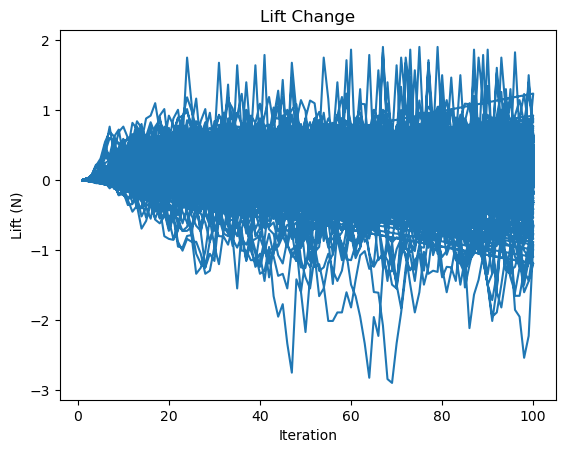

In [28]:
import matplotlib.pyplot as plt
#This is the plot of all of the 100 steps in each of the 1000 episodes (plotted over each other)
table2 = np.array(table2)

#Extract values from Table2
iteration = table2[:,4]
lift_plot = table2[:,2]
angle = table2[:100,1]
speed = table2[:,0]
reward_plot = table2[:,3]

# Plot the function using Matplotlib
plt.plot(iteration, lift_plot)

# Add axis labels and a title
plt.xlabel('Iteration')
plt.ylabel('Lift (N)')
plt.title('Lift Change')

# Show the plot
plt.show()



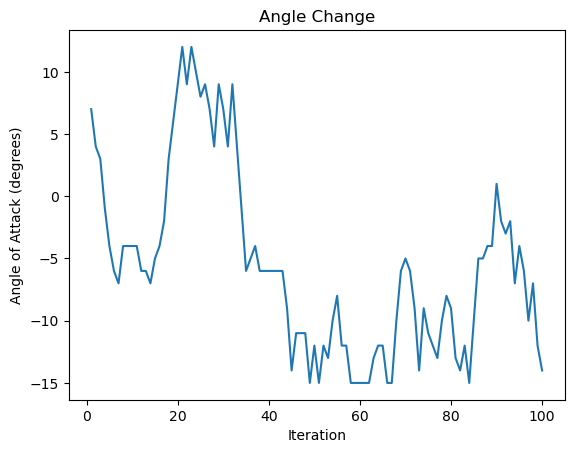

In [46]:
# Plot the function using Matplotlib
angle_fragment = table2[300:400,1] #samples only one of the episodes
iteration_fragment = table2[:100,4]
plt.plot(iteration_fragment, angle_fragment)

# Add axis labels and a title
plt.xlabel('Iteration')
plt.ylabel('Angle of Attack (degrees)')
plt.title('Angle Change')

# Show the plot
plt.show()

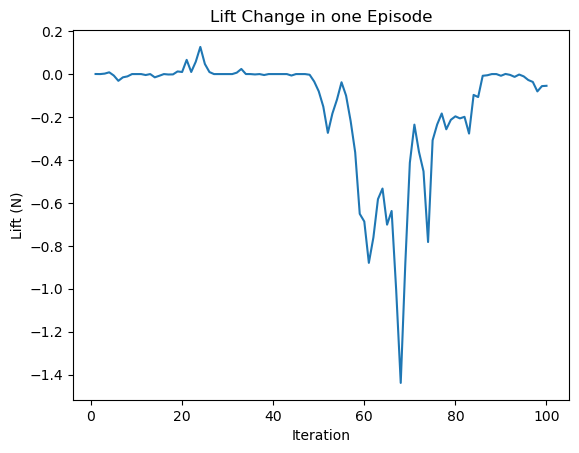

In [45]:
# Plot the function using Matplotlib
lift_fragment = table2[300:400,2] #samples only one of the episodes
iteration_fragment = table2[100:200,4]
plt.plot(iteration_fragment, lift_fragment)

# Add axis labels and a title
plt.xlabel('Iteration')
plt.ylabel('Lift (N)')
plt.title('Lift Change in one Episode')

# Show the plot
plt.show()

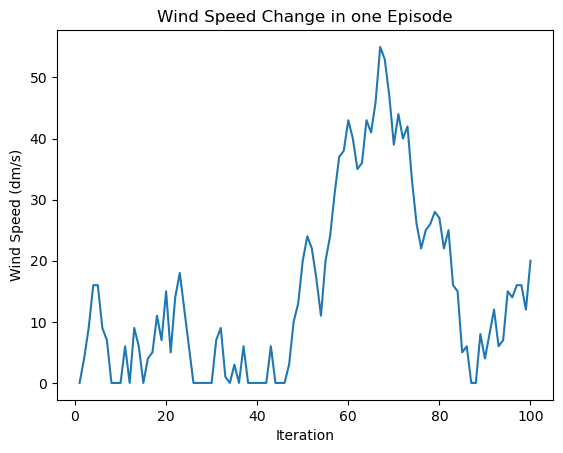

In [44]:
# Plot the function using Matplotlib
speed_fragment = table2[300:400,0] #samples only one of the episodes
iteration_fragment = table2[100:200,4]
plt.plot(iteration_fragment, speed_fragment)

# Add axis labels and a title
plt.xlabel('Iteration')
plt.ylabel('Wind Speed (dm/s)')
plt.title('Wind Speed Change in one Episode')

# Show the plot
plt.show()

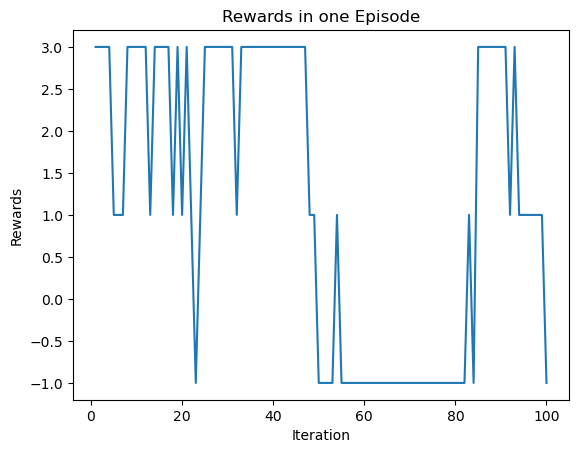

In [48]:
# Plot the function using Matplotlib
reward_fragment = table2[300:400,3] #samples only one of the episodes
iteration_fragment = table2[100:200,4]
plt.plot(iteration_fragment, reward_fragment)

# Add axis labels and a title
plt.xlabel('Iteration')
plt.ylabel('Rewards')
plt.title('Rewards in one Episode')

# Show the plot
plt.show()

In [49]:
# save current Q-table (Trained model)
np.save('beta_1.npy', q_table)

In [50]:
#The following is a demonstration on how to load the model for its use in other codes that have no training:
model = np.load('beta_1.npy')
model

array([[[-1.53419645, -1.54575937, -1.51458289, ..., -1.51082929,
         -1.54643503, -1.52737054],
        [-1.51030438, -1.54791348, -1.53336902, ..., -1.5557926 ,
         -1.49053466, -1.49939573],
        [-1.62775352, -1.62782392, -1.61408735, ..., -1.6153518 ,
         -1.56787956, -1.55120447],
        ...,
        [-1.42796419, -1.41389204, -1.33661383, ..., -1.43211499,
         -1.46380452, -1.41059779],
        [-1.43817393, -1.48250671, -1.46160377, ..., -1.47313187,
         -1.41699603, -1.42333693],
        [-1.4557534 , -1.5017307 , -1.48233315, ..., -1.52031397,
         -1.51110578, -1.49107696]],

       [[-0.47168832, -0.45914637, -0.41932402, ..., -0.57069197,
         -0.50009716, -0.46113013],
        [-0.48954651, -0.50037581, -0.53463324, ..., -0.49978456,
         -0.47475506, -0.48420303],
        [-0.57241616, -0.53131177, -0.63710621, ..., -0.52159135,
         -0.58333416, -0.593237  ],
        ...,
        [-0.50044856, -0.38461097, -0.4686306 , ..., -